Create a dataframe with timelines from Q3 2022-23

In [18]:
import pandas as pd
import json

# read the JSONL file
with open('data/timelines/json/july_sep_2022_congress_twitter_activity.jsonl', 'r', encoding='utf8') as f:
    lines = f.readlines()

# convert each JSON object to a dictionary and store in a list
data = []
for line in lines:
    data.append(json.loads(line))

# create a dataframe from the list of dictionaries
df = pd.DataFrame(data)


In [19]:
tweets = []
for tweet in df['data']:
    for t in tweet:
        tweet_dict = {}
        tweet_dict['user_id'] = t['author_id']
        tweet_dict['text'] = t['text']
        tweet_dict['created_at'] = t['created_at']
        tweets.append(tweet_dict)

df_tweets = pd.DataFrame(tweets)

In [20]:
df_tweets.to_csv('data/timelines/csv/2022_Q3_tweets_congress.csv', index=False)

### Descriptive Analysis

First we read in the dataframe.

In [77]:
import pandas as pd
from datetime import datetime

# get timelines
q3_tweets = pd.read_csv('data/timelines/csv/2022_Q3_tweets_congress.csv', dtype={'user_id': str})

# get metadata on twitter accounts
accounts_ids = pd.read_csv('data/congressmen_id_data.csv', dtype={'id': str}).rename({'created_at':'account_creation'}, axis=1)

# merge tweets with metatdata
q3_tweets = q3_tweets.merge(accounts_ids, how='left', left_on='user_id', right_on='id')

# convert created at to date object
q3_tweets['created_at'] = pd.to_datetime(q3_tweets['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))

print('number of tweets:', q3_tweets.__len__())
print('number of unique ids:', q3_tweets.user_id.nunique())
print('number of accounts:', accounts_ids.__len__())

length of dataframe: 114941
number of unique ids: 503
number of accounts: 511


The number of congressmen don't match the number of unique ids returned when we pull the timelines. Below are some twitter accounts that don't have any tweets in the time period we pulled:

In [80]:
accounts_ids[~accounts_ids.id.isin(q3_tweets.user_id)]['username'].head()

10         SenatorBurr
56     SenatorMarshall
75            SenSasse
146         KenCalvert
181    RepRickCrawford
Name: username, dtype: object

After looking up Senator Burr's twitter account, it appears he hasn't tweeted since 2020, so it checks out.

### How often do congressmembers tweet?

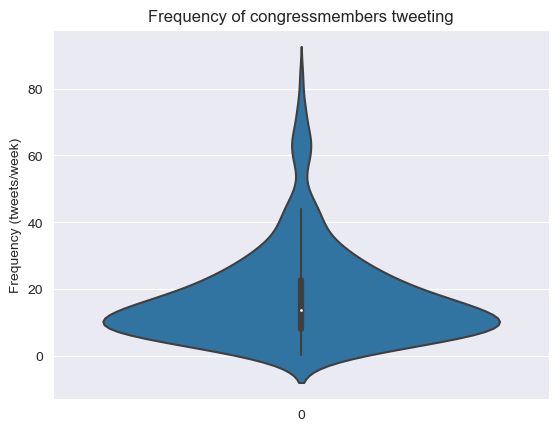

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

# Number of time period:
num_weeks = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days / 7
# num_hours = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days * 24
# num_days = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days

# Group the DataFrame by user ID and count the number of entries for each user
num_tweets_per_week = q3_tweets.groupby('name').agg({'created_at':'count'}).apply(lambda x: x/num_weeks).sort_values(by='created_at').created_at

sns.violinplot(num_tweets_per_week)
# Set the y-axis label using matplotlib
plt.ylabel('Frequency (tweets/week)')
plt.title('Frequency of congressmembers tweeting')
# Show the plot
plt.show()

So it appears the majority of congressmembers tweet approximately 10 times a week (a little more than once a day), while some are super-tweeters (80 times a weeks or more than 10 times a day), and plenty also don't tweet a lot.

### What does twitter activity look like over time?

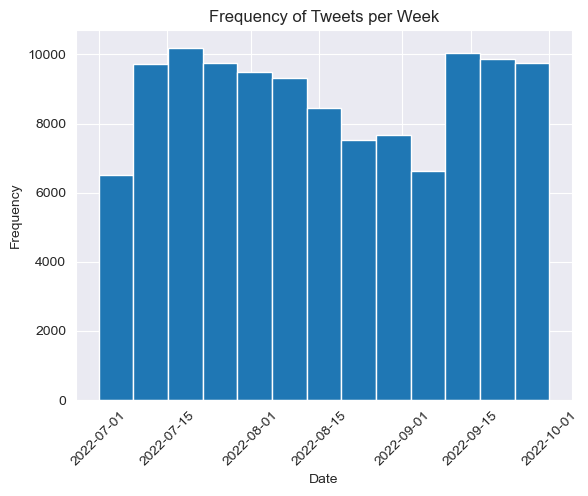

In [151]:
fig = q3_tweets.created_at.hist(bins=round(num_weeks), xrot=45)
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.title('Frequency of Tweets per Week')
plt.show()

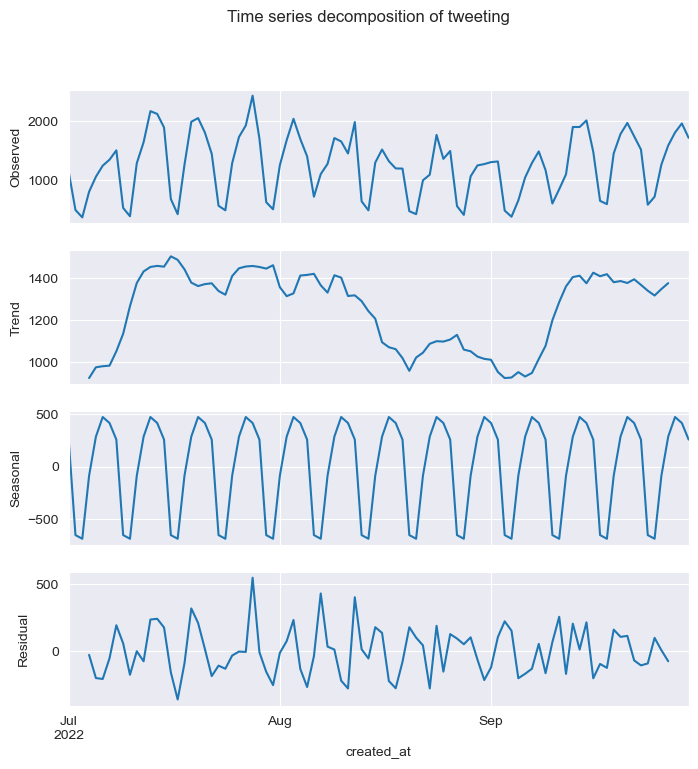

In [153]:
import statsmodels.api as sm

# Group the data by week and count the number of occurrences
weekly_counts = q3_tweets.groupby(pd.Grouper(key='created_at', freq='D'))['created_at'].count().to_frame().rename({'created_at':'count'}, axis=1).reset_index()

# Set the index of the DataFrame to the date column
weekly_counts.set_index('created_at', inplace=True)

# Decompose the time series into its trend, seasonal, and residual components
decomposition = sm.tsa.seasonal_decompose(weekly_counts, model='additive')

# Visualize the results
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.suptitle('Time series decomposition of tweeting')
plt.show()

Based on the two visualizations above, we can see that there's an overall trend of twitter activity, while also seasonal variation that's probably dependent on the day of the week.

### How often do congressmembers tweet depending on the time of day?

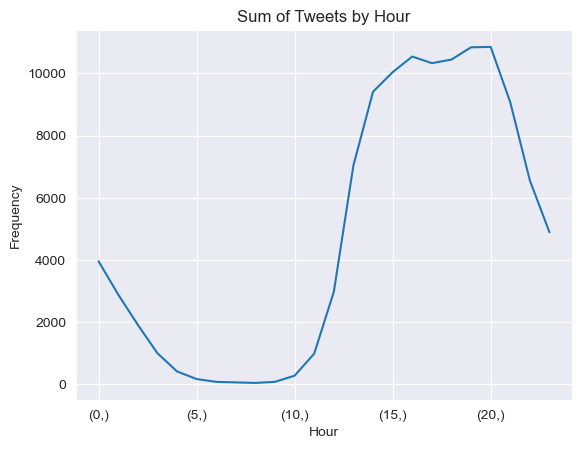

In [191]:
q3_tweets.created_at.apply(lambda x: x.hour).to_frame().value_counts().sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Sum of Tweets by Hour')
plt.show()

Note: I am not sure if this is CET or UTC.